# PESNet

This notebook contains a schematic neural network architecture for producing potential energy surfaces for given nucleus. The input to the network is [A,Z,Q20,Q30], with the output being the energy. 

The philosophy behind this structure is to produce a network that can quickly produce full surfaces for nuclei, perhaps as a guiding light for a HFB calculation. The network isn't expected to work well for extrapolation beyond the training set of nuclei, where the PES may have exotic behavior. An alternate method to produce surfaces would be to train a network that, instead, takes a few points as input (say 5%-10% of a surface) to then supersample the rest of the surface. The problems with this approach is that you are relying on a set Q20, Q30 grid for reconstruction and that supersampling from 5% isn't going to be very reliable.

The default method of training is to first set aside 20% of the data aside for training, and then split the remaining data into an 80/20 split for training and validation, respectively.

A secondary method of training is to actively exclude nuclei to benchmark the performance on whole surfaces. This can be done for a few nuclei, though one should probably disable the test split if you're excluding several whole nuclei.

The current notebook has a few different training cells, with the last one setting up a 'worst-case' scenario leaving out certain nuclei and separating out a large (50%) test set. This is good for testing extrapolation problems.



In [7]:
import os
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
import sklearn as sk
from pylab import plt, mpl
from pickle import dump, load
#from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def PESpredict(X, model, scaler):
    X = np.asarray(X)
    X = X.T
    xx = scaler.transform(X)
    pes=model.predict(xx)
    
    return pes.T.squeeze()


def NucError(A,Z,df,model,scaler):
    PES_sub = df[(df['A'] == A) & (df['Z'] == Z)]

    print("Nucleus: A =",int(A)," Z =",int(Z))

    A = PES_sub['A']
    Z = PES_sub['Z']
    Q20 = PES_sub['Q20']
    Q30 = PES_sub['Q30']
    E = PES_sub['HFB_cubic']

    xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())

    pes = PESpredict(xx, model, scaler)

    print("Chosen nucleus error: ",sum((pes - np.asarray(E))**2)/pes.size)
    
def PlotSurface(A,Z,df,model,scaler):
    PES_sub = df[(df['A'] == A) & (df['Z'] == Z)]

    A = PES_sub['A']
    Z = PES_sub['Z']
    Q20 = PES_sub['Q20']
    Q30 = PES_sub['Q30']
    E = PES_sub['HFB_cubic']

    xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())

    pes = PESpredict(xx, model, scaler)
    
    fig, axs = plt.subplots(1,2,figsize=(20,8), gridspec_kw={'width_ratios': [0.8, 1]})

    # Plot the surface.
    cmp = 'coolwarm'

    surf = axs[0].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)))#, cmap=mpl.cm.seismic)
    axs[0].set_title("From Data")
    img = axs[0].imshow(np.reshape(E.to_numpy(),(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
    surf = axs[1].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(pes,(126,21)))#, cmap=mpl.cm.seismic)
    axs[1].set_title("From NN")
    img = axs[1].imshow(np.reshape(pes,(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
    fig.colorbar(img)

    plt.show()

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Data/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

Default GPU Device: /device:GPU:0
Num GPUs Available:  1


Nucleus: A = 304  Z = 100
Chosen nucleus error:  0.013243273360042235
Nucleus: A = 232  Z = 88
Chosen nucleus error:  0.029001361198279334
Nucleus: A = 264  Z = 94
Chosen nucleus error:  0.03395586079180173
Nucleus: A = 282  Z = 94
Chosen nucleus error:  0.013494524177261245
Nucleus: A = 360  Z = 110
Chosen nucleus error:  0.021784193203877176
Nucleus: A = 238  Z = 94
Chosen nucleus error:  0.03697668970016218
Nucleus: A = 256  Z = 98
Chosen nucleus error:  0.04690798998576901
Nucleus: A = 324  Z = 108
Chosen nucleus error:  0.023043552605558314


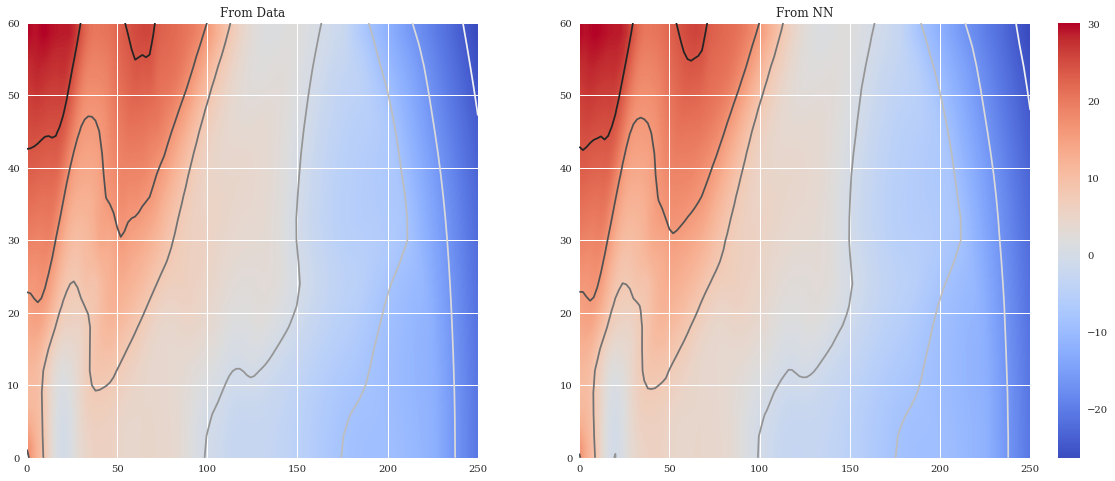

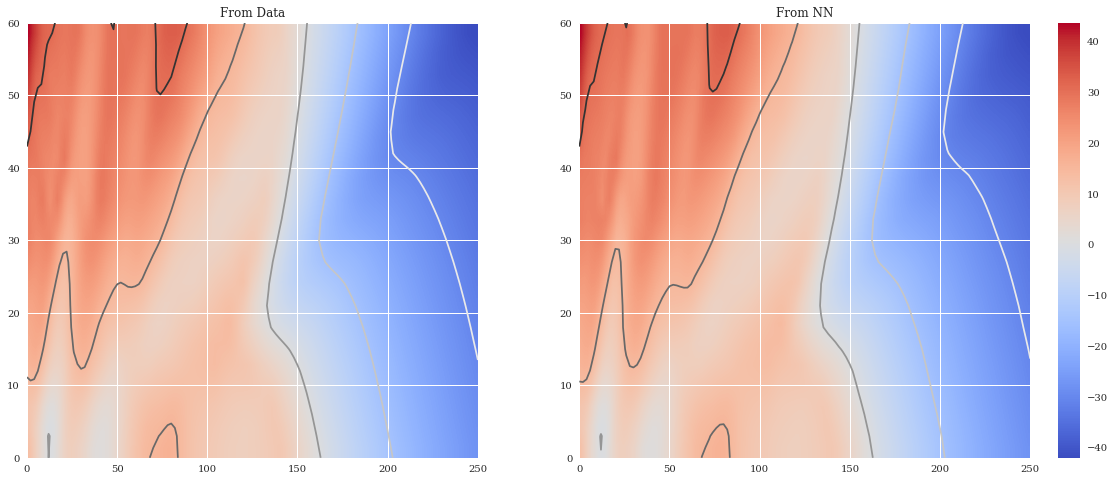

In [9]:
model = tf.keras.models.load_model('saved_model/PESNet.model',custom_objects={'R2':R2})
xscaler = load( open( 'pickles/xscaler.pkl', "rb" ) )

infile = open(data_path("All.dat"),'r')

PESfull = pd.read_csv(infile,delim_whitespace=True,low_memory=False)

NucError(304,100,PESfull,model,xscaler)
NucError(232,88,PESfull,model,xscaler)
NucError(264,94,PESfull,model,xscaler)
NucError(282,94,PESfull,model,xscaler)
NucError(360,110,PESfull,model,xscaler)
NucError(238,94,PESfull,model,xscaler)
NucError(256,98,PESfull,model,xscaler)
NucError(324,108,PESfull,model,xscaler)

PlotSurface(304,100,PESfull,model,xscaler)
PlotSurface(232,88,PESfull,model,xscaler)

Epoch 1/1000
273/273 [==============================] - 1s 3ms/step - loss: 31.1152 - R2: 0.9252 - val_loss: 12.7032 - val_R2: 0.9697
Epoch 2/1000
273/273 [==============================] - 1s 3ms/step - loss: 8.4325 - R2: 0.9796 - val_loss: 6.9763 - val_R2: 0.9834
Epoch 3/1000
273/273 [==============================] - 1s 3ms/step - loss: 5.5735 - R2: 0.9865 - val_loss: 4.5341 - val_R2: 0.9892
Epoch 4/1000
273/273 [==============================] - 1s 3ms/step - loss: 3.9670 - R2: 0.9904 - val_loss: 3.3684 - val_R2: 0.9920
Epoch 5/1000
273/273 [==============================] - 1s 3ms/step - loss: 2.8353 - R2: 0.9932 - val_loss: 2.5871 - val_R2: 0.9938
Epoch 6/1000
273/273 [==============================] - 1s 3ms/step - loss: 2.1619 - R2: 0.9948 - val_loss: 1.8603 - val_R2: 0.9956
Epoch 7/1000
273/273 [==============================] - 1s 3ms/step - loss: 1.8607 - R2: 0.9955 - val_loss: 2.5579 - val_R2: 0.9939
Epoch 8/1000
273/273 [==============================] - 1s 3ms/step - loss

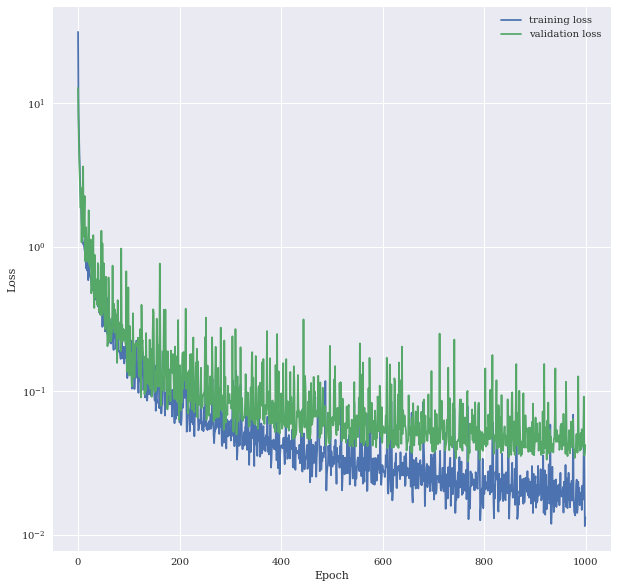

In [21]:


infile = open(data_path("All.dat"),'r')

PES = pd.read_csv(infile,delim_whitespace=True,low_memory=False)
# PES = PESfull[~((PESfull['A'] == 304) & (PESfull['Z'] == 100))]
# PES = PES[~((PES['A'] == 232) & (PES['Z'] == 88))]
# PES = PES[~((PES['A'] == 264) & (PES['Z'] == 94))]
# PES = PES[~((PES['A'] == 282) & (PES['Z'] == 94))]
# PES = PES[~((PES['A'] == 360) & (PES['Z'] == 110))]
# PES = PES[~((PES['A'] == 238) & (PES['Z'] == 94))]
# PES = PES[~((PES['A'] == 256) & (PES['Z'] == 98))]
# PES = PES[~((PES['A'] == 324) & (PES['Z'] == 108))]

#print(PES[(PES['A'] != 304) & (PES['Z'] != 100)])

A = PES['A']
Z = PES['Z']
Q20 = PES['Q20']
Q30 = PES['Q30']
E = PES['HFB_cubic']

# Build input array
xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())
xx = np.asarray(xx)
xx = xx.T

yy = np.asarray(E).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.25,random_state=42)
x_train,y_train = sk.utils.shuffle(x_train,y_train, random_state=42)
#x_train=xx
#y_train=yy
# Scale input

xscaler = RobustScaler(unit_variance=True)#MinMaxScaler()
xscaler.fit(xx)

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

#yscaler = MinMaxScaler()
#yscaler.fit(y_train)

ys_train = y_train#yscaler.transform(y_train)
ys_test = y_test#yscaler.transform(y_test)
ys_full = yy#yscaler.transform(yy)

nodes = 500
activation="relu"
activation = tf.keras.layers.PReLU()
model=tf.keras.Sequential() #Define the model object
# model.add(tf.keras.layers.Dense(2048,input_shape=(4,),activation=activation))
# #model.add(tf.keras.layers.Dense(2048,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(1024,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(512,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(256,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(128,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(64,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(32,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(16,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(8,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(4,activation=activation)) #Add the hidden layer
# #model.add(tf.keras.layers.Dense(2,activation=activation)) #Add the hidden layer
# model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(4,),activation=activation))
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
#model.compile(tf.keras.optimizers.Adadelta(),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=1000, batch_size=512, validation_split=0.35,verbose=1,shuffle=True)
history = results.history
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
ax.set_yscale("log", nonpositive='clip')
#plt.ylim(0,1)
plt.show()

# test loss calculation

#[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

#print('Test Loss: {:.04}'.format(test_loss))
#print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = trainen_out.T.squeeze()#yscaler.inverse_transform(trainen_out).T.squeeze()
testen_out = testen_out.T.squeeze()#yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = fullen_out.T.squeeze()#yscaler.inverse_transform(fullen_out).T.squeeze()

a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

Nucleus: A = 360  Z = 110
Chosen nucleus error:  0.021784193203877176
Training error:  0.027165567504579383
Test set error:  0.04156965908823146


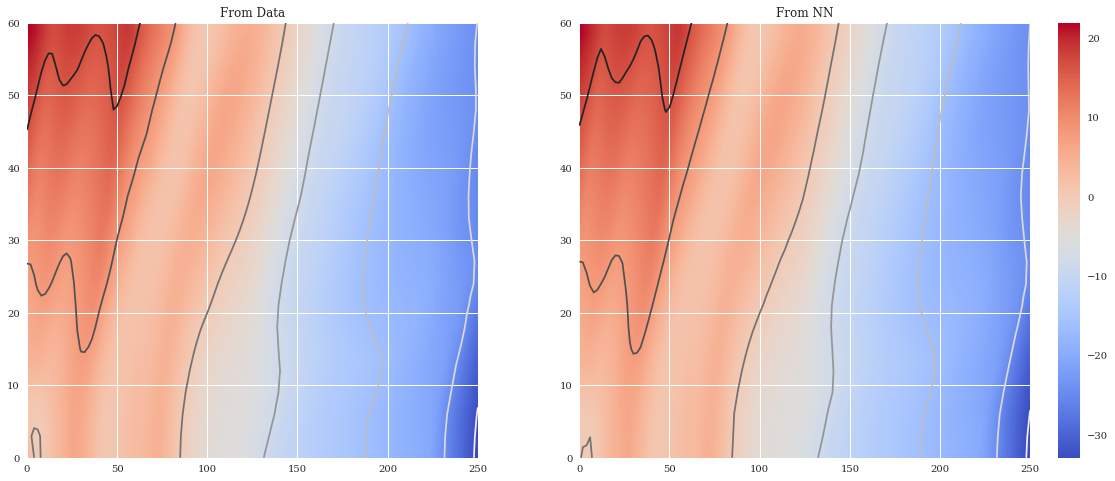

In [22]:
model_mse = model

#PES = PESfull[ (((PESfull['A'] != 304) & (PESfull['Z'] != 100)))]
PESfull = PES
A=360.0
Z=110.0

PES_sub = PESfull[(PESfull['A'] == A) & (PESfull['Z'] == Z)]

print("Nucleus: A =",int(A)," Z =",int(Z))

A = PES_sub['A']
Z = PES_sub['Z']
Q20 = PES_sub['Q20']
Q30 = PES_sub['Q30']
E = PES_sub['HFB_cubic']

xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())
xx = np.asarray(xx)
xx = xx.T

xs_full = xscaler.transform(xx)

yy = np.asarray(E).reshape(-1, 1)

#ys_full = yscaler.transform(yy)

#model.evaluate(xs_test, ys_test, verbose=1)
pes=model_mse.predict(xs_full)

# Shift back for plotting

x_full = xscaler.inverse_transform(xs_full)

fullen_out = pes.T.squeeze()#yscaler.inverse_transform(pes).T.squeeze()

print("Chosen nucleus error: ",sum((fullen_out - np.asarray(E))**2)/fullen_out.size)

#print(traindiff)
t2 = traindiff**2
print("Training error: ",sum(t2)/traindiff.size)

t2 = diff**2
print("Test set error: ",sum(t2)/diff.size)


fig, axs = plt.subplots(1,2,figsize=(20,8), gridspec_kw={'width_ratios': [0.8, 1]})
#im = ax.imshow(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)), interpolation='bilinear', origin='lower')#,cmap=mpl.cm.seismic)

# Plot the surface.

cmp = 'coolwarm'

surf = axs[0].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)))#, cmap=mpl.cm.seismic)
axs[0].set_title("From Data")
img = axs[0].imshow(np.reshape(E.to_numpy(),(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
surf = axs[1].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(fullen_out,(126,21)))#, cmap=mpl.cm.seismic)
axs[1].set_title("From NN")
img = axs[1].imshow(np.reshape(fullen_out,(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
fig.colorbar(img)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)

#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#cbar = fig.colorbar(surf)
plt.show()


Epoch 1/1000
168/168 [==============================] - 1s 3ms/step - loss: 66.0465 - R2: 0.8438 - val_loss: 14.8786 - val_R2: 0.9646
Epoch 2/1000
168/168 [==============================] - 0s 3ms/step - loss: 12.5605 - R2: 0.9701 - val_loss: 11.1514 - val_R2: 0.9735
Epoch 3/1000
168/168 [==============================] - 0s 3ms/step - loss: 9.1116 - R2: 0.9783 - val_loss: 8.6812 - val_R2: 0.9794
Epoch 4/1000
168/168 [==============================] - 1s 4ms/step - loss: 7.1139 - R2: 0.9831 - val_loss: 5.4972 - val_R2: 0.9869
Epoch 5/1000
168/168 [==============================] - 0s 3ms/step - loss: 5.3721 - R2: 0.9872 - val_loss: 4.2178 - val_R2: 0.9900
Epoch 6/1000
168/168 [==============================] - 0s 3ms/step - loss: 4.4312 - R2: 0.9894 - val_loss: 3.9276 - val_R2: 0.9907
Epoch 7/1000
168/168 [==============================] - 0s 3ms/step - loss: 3.7754 - R2: 0.9910 - val_loss: 4.3028 - val_R2: 0.9898
Epoch 8/1000
168/168 [==============================] - 0s 3ms/step - lo

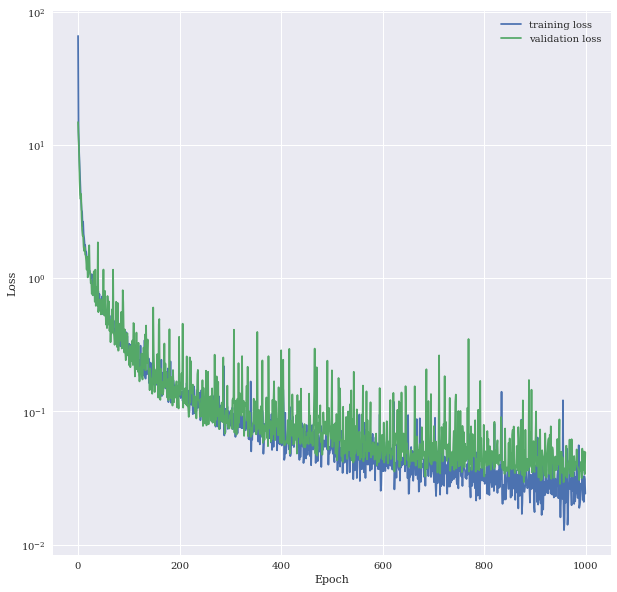

NameError: name 'trained_out' is not defined

In [28]:
infile = open(data_path("All.dat"),'r')

# Read the experimental data with Pandas
# Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
#               names=('N', 'Z', 'A', 'Element', 'Ebinding'),
#               widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
#               header=39,
#               index_col=False)
PESfull = pd.read_csv(infile,delim_whitespace=True,low_memory=False)
PES = PESfull[~((PESfull['A'] == 304) & (PESfull['Z'] == 100))]
PES = PES[~((PES['A'] == 232) & (PES['Z'] == 88))]
PES = PES[~((PES['A'] == 264) & (PES['Z'] == 94))]
PES = PES[~((PES['A'] == 282) & (PES['Z'] == 94))]
PES = PES[~((PES['A'] == 360) & (PES['Z'] == 110))]
PES = PES[~((PES['A'] == 238) & (PES['Z'] == 94))]
PES = PES[~((PES['A'] == 256) & (PES['Z'] == 98))]
PES = PES[~((PES['A'] == 324) & (PES['Z'] == 108))]

A = PES['A']
Z = PES['Z']
Q20 = PES['Q20']
Q30 = PES['Q30']
E = PES['HFB_cubic']

# Build input array
xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())
xx = np.asarray(xx)
xx = xx.T

yy = np.asarray(E).reshape(-1, 1)

# Get a test set for later
#x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)
x_train,y_train = sk.utils.shuffle(xx,yy, random_state=42)

#x_train = xx
#y_train = yy
# Scale input

xscaler = MinMaxScaler()
xscaler.fit(x_train)

xs_train = xscaler.transform(x_train)
#xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler = MinMaxScaler()
yscaler.fit(y_train)

ys_train = y_train#yscaler.transform(y_train)
#ys_test = yscaler.transform(y_test)
ys_full = yy#yscaler.transform(yy)

nodes = 250
activation="relu"
activation = tf.keras.layers.PReLU()
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(4,),activation=activation))
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
#model.compile(tf.keras.optimizers.Adadelta(),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=1000, batch_size=1024, validation_split=0.35,shuffle=True)
history = results.history
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
ax.set_yscale("log", nonpositive='clip')
#plt.ylim(0,1)
plt.show()

# test loss calculation

#[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

#print('Test Loss: {:.04}'.format(test_loss))
#print('Test R2: {:.04}'.format(test_R2))

#testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
#x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = trainen_out.T.squeeze()#yscaler.inverse_transform(trainen_out).T.squeeze()
#testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = fullen_out.T.squeeze()#yscaler.inverse_transform(fullen_out).T.squeeze()

#a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

#en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

#diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

#diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

#x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
#diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

Nucleus: A = 256  Z = 98
Chosen nucleus error:  0.23669289217074052
Training error:  0.06576703931130648


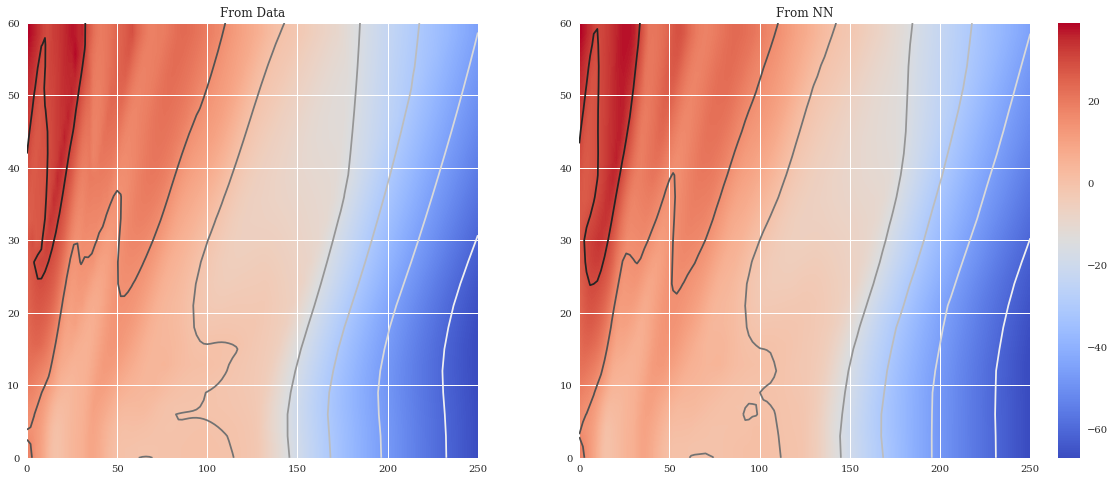

In [55]:
#model_msle = model 

A=256.0
Z=98.0

PES_sub = PESfull[(PESfull['A'] == A) & (PESfull['Z'] == Z)]

print("Nucleus: A =",int(A)," Z =",int(Z))

A = PES_sub['A']
Z = PES_sub['Z']
Q20 = PES_sub['Q20']
Q30 = PES_sub['Q30']
E = PES_sub['HFB_cubic']

xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())
xx = np.asarray(xx)
xx = xx.T

xs_full = xscaler.transform(xx)

yy = np.asarray(E).reshape(-1, 1)

#model.evaluate(xs_test, ys_test, verbose=1)
pes=model.predict(xs_full)

# Shift back for plotting

x_full = xscaler.inverse_transform(xs_full)

fullen_out = pes.T.squeeze()#yscaler.inverse_transform(pes).T.squeeze()

print("Chosen nucleus error: ",sum((fullen_out - np.asarray(E))**2)/fullen_out.size)

#print(traindiff)
traindiff = trainen_test-trainen_out.T.squeeze()

t2 = traindiff**2
print("Training error: ",sum(t2)/traindiff.size)

#t2 = diff**2
#print("Test set error: ",sum(t2)/diff.size)


fig, axs = plt.subplots(1,2,figsize=(20,8), gridspec_kw={'width_ratios': [0.8, 1]})
#im = ax.imshow(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)), interpolation='bilinear', origin='lower')#,cmap=mpl.cm.seismic)

# Plot the surface.

cmp = 'coolwarm'

surf = axs[0].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)))#, cmap=mpl.cm.seismic)
axs[0].set_title("From Data")
img = axs[0].imshow(np.reshape(E.to_numpy(),(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
surf = axs[1].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(fullen_out,(126,21)))#, cmap=mpl.cm.seismic)
axs[1].set_title("From NN")
img = axs[1].imshow(np.reshape(fullen_out,(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
fig.colorbar(img)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)

#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#cbar = fig.colorbar(surf)
plt.show()


In [27]:
# !mkdir -p saved_model
# model.save('saved_model/PESNet.model')
# model.save('saved_model/PESNet_NNDrop.model')
# Saved model with standard test/training.val splits:
# Training error:  0.027165567504579383
# Test set error:  0.04156965908823146
# !mkdir -p pickles
# save the scaler
# dump(xscaler, open('pickles/xscaler.pkl', 'wb'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 500)               3000      
_________________________________________________________________
dense_87 (Dense)             (None, 500)               251000    
_________________________________________________________________
dense_88 (Dense)             (None, 500)               251000    
_________________________________________________________________
dense_89 (Dense)             (None, 500)               251000    
_________________________________________________________________
dense_90 (Dense)             (None, 500)               251000    
_________________________________________________________________
dense_91 (Dense)             (None, 500)               251000    
_________________________________________________________________
dense_92 (Dense)             (None, 1)               

Epoch 1/1000
104/104 [==============================] - 0s 3ms/step - loss: 124.7420 - R2: 0.7070 - val_loss: 23.9189 - val_R2: 0.9433
Epoch 2/1000
104/104 [==============================] - 0s 2ms/step - loss: 19.3258 - R2: 0.9541 - val_loss: 16.6914 - val_R2: 0.9604
Epoch 3/1000
104/104 [==============================] - 0s 2ms/step - loss: 13.2846 - R2: 0.9684 - val_loss: 11.2617 - val_R2: 0.9733
Epoch 4/1000
104/104 [==============================] - 0s 2ms/step - loss: 10.9989 - R2: 0.9739 - val_loss: 9.9689 - val_R2: 0.9763
Epoch 5/1000
104/104 [==============================] - 0s 2ms/step - loss: 9.2422 - R2: 0.9780 - val_loss: 9.2153 - val_R2: 0.9781
Epoch 6/1000
104/104 [==============================] - 0s 2ms/step - loss: 7.8174 - R2: 0.9815 - val_loss: 6.8804 - val_R2: 0.9837
Epoch 7/1000
104/104 [==============================] - 0s 2ms/step - loss: 6.4541 - R2: 0.9847 - val_loss: 5.5273 - val_R2: 0.9869
Epoch 8/1000
104/104 [==============================] - 0s 2ms/step 

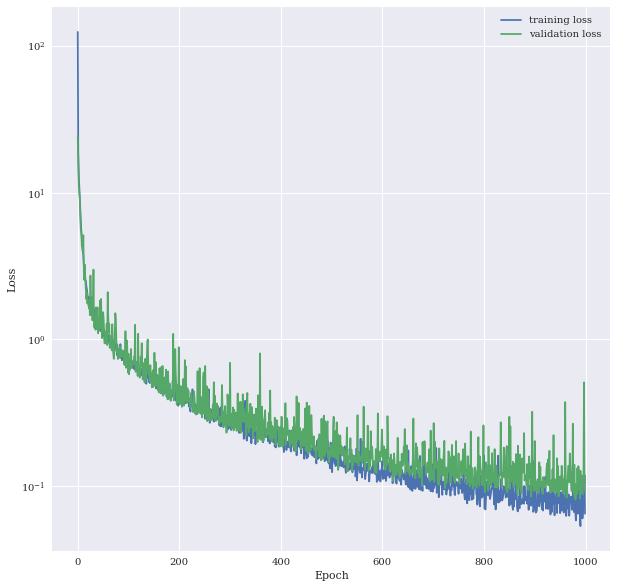

In [53]:
infile = open(data_path("All.dat"),'r')

# Read the experimental data with Pandas
# Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
#               names=('N', 'Z', 'A', 'Element', 'Ebinding'),
#               widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
#               header=39,
#               index_col=False)
PES = pd.read_csv(infile,delim_whitespace=True,low_memory=False)
PES = PES[~((PES['A'] == 304) & (PES['Z'] == 100))]
PES = PES[~((PES['A'] == 232) & (PES['Z'] == 88))]
PES = PES[~((PES['A'] == 264) & (PES['Z'] == 94))]
PES = PES[~((PES['A'] == 282) & (PES['Z'] == 94))]
PES = PES[~((PES['A'] == 360) & (PES['Z'] == 110))]
PES = PES[~((PES['A'] == 238) & (PES['Z'] == 94))]
PES = PES[~((PES['A'] == 256) & (PES['Z'] == 98))]
PES = PES[~((PES['A'] == 324) & (PES['Z'] == 108))]

A = PES['A']
Z = PES['Z']
Q20 = PES['Q20']
Q30 = PES['Q30']
E = PES['HFB_cubic']

# Build input array
xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())
xx = np.asarray(xx)
xx = xx.T

yy = np.asarray(E).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.5,random_state=42)
x_train,y_train = sk.utils.shuffle(x_train,y_train, random_state=42)

#x_train = xx
#y_train = yy
# Scale input

xscaler = MinMaxScaler()
xscaler.fit(x_train)

xs_train = xscaler.transform(x_train)
#xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler = MinMaxScaler()
yscaler.fit(y_train)

ys_train = y_train#yscaler.transform(y_train)
#ys_test = yscaler.transform(y_test)
ys_full = yy#yscaler.transform(yy)

nodes = 150
activation="relu"
activation = tf.keras.layers.PReLU()
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(4,),activation=activation))
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
#model.compile(tf.keras.optimizers.Adadelta(),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=1000, batch_size=1024, validation_split=0.2,shuffle=True)
history = results.history
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
ax.set_yscale("log", nonpositive='clip')
#plt.ylim(0,1)
plt.show()

# test loss calculation

#[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

#print('Test Loss: {:.04}'.format(test_loss))
#print('Test R2: {:.04}'.format(test_R2))

#testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
#x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = trainen_out.T.squeeze()#yscaler.inverse_transform(trainen_out).T.squeeze()
#testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = fullen_out.T.squeeze()#yscaler.inverse_transform(fullen_out).T.squeeze()

#a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

#en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

#diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

#diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

#x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
#diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

Nucleus: A = 232  Z = 88
Chosen nucleus error:  0.029001361198279334
Training error:  0.027165567504579383


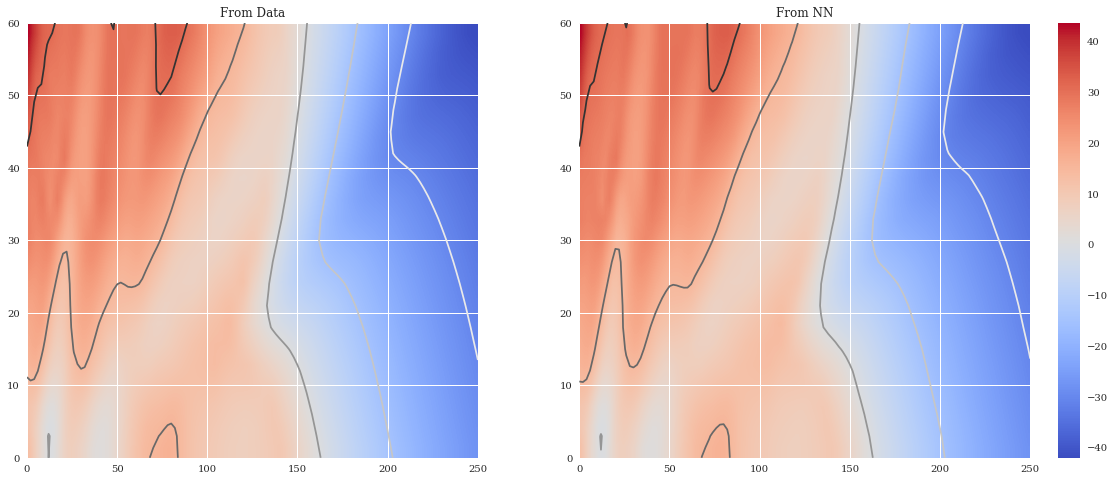

In [24]:
#model_msle = model 

A=232.0
Z=88.0

PES_sub = PESfull[(PESfull['A'] == A) & (PESfull['Z'] == Z)]

print("Nucleus: A =",int(A)," Z =",int(Z))

A = PES_sub['A']
Z = PES_sub['Z']
Q20 = PES_sub['Q20']
Q30 = PES_sub['Q30']
E = PES_sub['HFB_cubic']

xx = (A.to_numpy(),Z.to_numpy(),Q20.to_numpy(),Q30.to_numpy())
xx = np.asarray(xx)
xx = xx.T

xs_full = xscaler.transform(xx)

yy = np.asarray(E).reshape(-1, 1)

#model.evaluate(xs_test, ys_test, verbose=1)
pes=model.predict(xs_full)

# Shift back for plotting

x_full = xscaler.inverse_transform(xs_full)

fullen_out = pes.T.squeeze()#yscaler.inverse_transform(pes).T.squeeze()

print("Chosen nucleus error: ",sum((fullen_out - np.asarray(E))**2)/fullen_out.size)

#print(traindiff)
traindiff = trainen_test-trainen_out.T.squeeze()

t2 = traindiff**2
print("Training error: ",sum(t2)/traindiff.size)

#t2 = diff**2
#print("Test set error: ",sum(t2)/diff.size)


fig, axs = plt.subplots(1,2,figsize=(20,8), gridspec_kw={'width_ratios': [0.8, 1]})
#im = ax.imshow(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)), interpolation='bilinear', origin='lower')#,cmap=mpl.cm.seismic)

# Plot the surface.

cmp = 'coolwarm'

surf = axs[0].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(E.to_numpy(),(126,21)))#, cmap=mpl.cm.seismic)
axs[0].set_title("From Data")
img = axs[0].imshow(np.reshape(E.to_numpy(),(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
surf = axs[1].contour(np.reshape(Q20.to_numpy(),(126,21)), np.reshape(Q30.to_numpy(),(126,21)), np.reshape(fullen_out,(126,21)))#, cmap=mpl.cm.seismic)
axs[1].set_title("From NN")
img = axs[1].imshow(np.reshape(fullen_out,(126,21)).T, extent=[0, 250, 0, 60], origin='lower',
           cmap=cmp,interpolation='bilinear',aspect="auto")
fig.colorbar(img)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)

#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#cbar = fig.colorbar(surf)
plt.show()
